In [3]:
# Importing libraries
import cv2
import numpy as np
from imageio import imread, imwrite
from scipy.ndimage.filters import convolve
from numba import jit
from matplotlib import pyplot as plt

In [4]:
!git clone https://github.com/ericsujw/InstColorization.git

Cloning into 'InstColorization'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 211 (delta 0), reused 2 (delta 0), pack-reused 208
Receiving objects: 100% (211/211), 6.11 MiB | 34.40 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [16]:
ls

000000022969.jpg*  574100c6e31a1dcd096476eb2d632b3c.jpg
000000023781.jpg*  8b01a894fb91025a1dc77611838e9d13.jpg
000000046872.jpg*  925f179ba736e15e89bfd6d88e0bba56.jpg
000000050145.jpg*  e9b6826aa623549ec77bbc0275002779.jpg


In [6]:
cd example/

/content/InstColorization/example


In [7]:
threshold_mask = 10 #pixel intensity minimum for binary mask
import os
print(os.getcwd())

/content/InstColorization/example


In [35]:
pwd

'/content/InstColorization/example'

In [26]:
# MAIN FUNCTIONS
import skimage.io
def load_image(path):
  """
  Parameters:
  path: String representing relative/absolute path to the image file

  Output: Numpy array of shape (width, height, channels)
  """
  return cv2.imread(path).astype(np.float32)

def image_rotate(image, clockwise):
    value = 1 if clockwise else 3
    return np.rot90(image, value) 



def getBrightness(image):
  """
  Parameters:
  image: Numpy array of shape (width, height)

  Output: 2D numpy array where each coordinate's value represents the average across the input 
  image's channels at that coordinate
  """
  width, height, channels = image.shape
  output = np.zeros((width, height))
  for w in range(width):
    for h in range(height):
      total_across_channels = 0
      for c in range(channels):
        total_across_channels += image[w][h][c]
      output[w][h] = int(total_across_channels/channels)
  return output

def computeEnergy(image):
    image = image.astype('float32')
    sobel_x =  np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])

    sobel_y = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])

    filter_x = np.stack([sobel_x]*3, axis=2)
    filter_y = np.stack([sobel_y]*3, axis=2)

    filtered = np.absolute(convolve(image, filter_x)) + np.absolute(convolve(image, filter_x))

    energy = filtered.sum(axis=2)

    return energy


def seamEnergyMap(image):
  width, height, channels = image.shape
  image_energy_map = computeEnergy(image)
  min_cumulative_energy = image_energy_map[: , :]
  direction = np.zeros((width, height), dtype=np.int)

  for x in range(1, width):
    for y in range(0, height):
      min_val = 0
      if y == 0:
        index = np.argmin(min_cumulative_energy[x-1, y:y+2])
        direction[x, y] = index + y
        min_val = min_cumulative_energy[x-1,  index + y]
      else:
        index = np.argmin(min_cumulative_energy[x-1, y-1:y+2])
        direction[x, y] = index + y - 1
        min_val = min_cumulative_energy[x-1,  index + y - 1]
      
      min_cumulative_energy[x,y] += min_val
  
  return min_cumulative_energy, direction


def seamIndex(image):
    width, height, channels = image.shape
    min_cumulative_energy, direction = seamEnergyMap(image)
    minSeamEnergyIndex = np.argmin(min_cumulative_energy[-1])
    seamIndexList = [0] * width
    seamIndexList[width-1] = minSeamEnergyIndex
    for i in range(width-1, -1, -1):
      minSeamEnergyIndex = direction[i, minSeamEnergyIndex]
      seamIndexList[i] = minSeamEnergyIndex
    return seamIndexList


def addSeam(image, seamIndex):
    rows, cols, channels = image.shape
    result = np.zeros((rows, cols + 1, channels))
    for r in range(rows):
      col = seamIndex[r]
      for c in range(channels):
        if col == 0:
          result[r, col, c] = image[r, col, c]
          result[r, col + 1, c] = np.average(image[r, col: col+2, c])
          result[r, col+2:, c] = image[r, col+1:, c]
        else:
          result[r, :col, c] = image[r, :col, c]
          result[r, col, c] = np.average(image[r, col-1: col+1, c])
          result[r, col+1:, c] = image[r, col:, c]
    return result



def reduceImageColumns(image, scale):
    width, height, channels = image.shape
    reduced_columns = int(height - scale*height)
    temp_image = image.copy()
    for i in range(reduced_columns):
      temp_image, drawn_image = removeColumn(temp_image)
      image_name = "./r" + str(i).zfill(3) +".jpg"
      drawn_image = np.float32(drawn_image)
      drawn_image =  cv2.cvtColor(drawn_image, cv2.COLOR_BGR2RGB)
      cv2.imwrite(image_name,  drawn_image)
      # new_drawn_image = skimage.io.imread(image_name)
      # cv2.imwrite(image_name, cv2.cvtColor(new_drawn_image, cv2.COLOR_RGB2BGR))
    return temp_image



# Optimize by reusing seamIndex function to find seam
def removeColumn(image):
  new_im = image * 1.0
  width, height, channels = image.shape
  min_cumulative_energy, direction = seamEnergyMap(image)
  removableElements = np.ones((width, height), dtype=np.bool)
  seam_index = [0]*width
  minSeamEnergyIndex = np.argmin(min_cumulative_energy[-1])
  seam_index[-1]  = minSeamEnergyIndex
  for i in range(width-1, -1, -1):
    removableElements[i, minSeamEnergyIndex] = False
    minSeamEnergyIndex = direction[i, minSeamEnergyIndex]
    seam_index[i] = minSeamEnergyIndex
  drawn_image = draw_seams(image * 1.0, seam_index)
  removableElements = np.stack([removableElements] * 3, axis=2)
  return image[removableElements].reshape((width, height-1, channels)), drawn_image

def reduceImageRows(image, scale):
  return np.rot90(reduceImageColumns(np.rot90(image, 1, (0,1)), scale), 3, (0,1))

def image_transpose(image):
      width, height, channels = image.shape
      return np.transpose(image, (1, 0, 2))

def seam_carving(image, resolution):
    return

def seam_carving2D(image, scaleX, scaleY):
    return reduceImageColumns(reduceImageRows(image, scaleY), scaleX)



def enlarge(image, scale):
    rows, cols, channels = image.shape    
    if scale < 1:
      print("Invalid argument: Scale needs to be greater than / equal to 1 for enlargement")
    elif scale == 1:
      return image
    else:
      enlarged_im, reduced_output, new_im = image * 1.0, image * 1.0, image * 1.0
      steps = int(scale * cols - cols)
      while steps > 0:
        seam = seamIndex(reduced_output)
        enlarged_im = addSeam(enlarged_im, seam)
        reduced_output, drawn_image = removeColumn(reduced_output)
        steps -= 1
    return enlarged_im

def enlarge2D(image, scale_X, scale_Y):
    rows, cols, channels = image.shape
    if (scale_X <= 1 or scale_Y <= 1):
      print ("Invalid argument: Scale needs to be greater than / equal to 1 for enlargement")
      return
    else:
      enlarged_X = enlarge(image, scale_X)
      transpose_enlargedX = image_transpose(enlarged_X);
      enlargedX_Y = enlarge(transpose_enlargedX, scale_Y);
      return image_transpose(enlargedX_Y);



#Needs to be edited and worked on
# def object_removal(im, rmask, mask=None, vis=False, horizontal_removal=False):
#     im = im.astype(np.float64)
#     rmask = rmask.astype(np.float64)
#     if mask is not None:
#         mask = mask.astype(np.float64)
#     output = im

#     h, w = im.shape[:2]

#     if horizontal_removal:
#         output = rotate_image(output, True)
#         rmask = rotate_image(rmask, True)
#         if mask is not None:
#             mask = rotate_image(mask, True)

#     while len(np.where(rmask > MASK_THRESHOLD)[0]) > 0:
#         seam_idx, boolmask = get_minimum_seam(output, mask, rmask)
#         if vis:
#             visualize(output, boolmask, rotate=horizontal_removal)            
#         output = remove_seam(output, boolmask)
#         rmask = remove_seam_grayscale(rmask, boolmask)
#         if mask is not None:
#             mask = remove_seam_grayscale(mask, boolmask)

#     num_add = (h if horizontal_removal else w) - output.shape[1]
#     output, mask = seams_insertion(output, num_add, mask, vis, rot=horizontal_removal)
#     if horizontal_removal:
#         output = image_rotate(output, False)

#     return output     



def draw_seams(im, seam):
  width, height, channels = im.shape
  for j in range(0, width):
    im[j, seam[j], 0] = 255
    im[j, seam[j], 1] = 0
    im[j, seam[j], 2] = 0

  return im




In [58]:
!zip -r download_example.zip example/
# !zip -r /content/file.zip /content/Folder_To_Zip

  adding: example/ (stored 0%)
  adding: example/r8.jpg (deflated 0%)
  adding: example/r243.jpg (deflated 1%)
  adding: example/r252.jpg (deflated 0%)
  adding: example/r226.jpg (deflated 0%)
  adding: example/r092.jpg (deflated 0%)
  adding: example/r095.jpg (deflated 0%)
  adding: example/r015.jpg (deflated 0%)
  adding: example/r68.jpg (deflated 0%)
  adding: example/r098.jpg (deflated 0%)
  adding: example/r146.jpg (deflated 0%)
  adding: example/r180.jpg (deflated 0%)
  adding: example/r024.jpg (deflated 0%)
  adding: example/r106.jpg (deflated 0%)
  adding: example/r42.jpg (deflated 0%)
  adding: example/r11.jpg (deflated 0%)
  adding: example/r10.jpg (deflated 0%)
  adding: example/r168.jpg (deflated 0%)
  adding: example/r275.jpg (deflated 1%)
  adding: example/r207.jpg (deflated 0%)
  adding: example/r234.jpg (deflated 0%)
  adding: example/r5.jpg (deflated 0%)
  adding: example/r122.jpg (deflated 0%)
  adding: example/r009.jpg (deflated 0%)
  adding: example/r040.jpg (deflat

In [63]:
from google.colab import files
files.download("./download_example.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
ls

000000022969.jpg*  574100c6e31a1dcd096476eb2d632b3c.jpg
000000023781.jpg*  8b01a894fb91025a1dc77611838e9d13.jpg
000000046872.jpg*  925f179ba736e15e89bfd6d88e0bba56.jpg
000000050145.jpg*  e9b6826aa623549ec77bbc0275002779.jpg


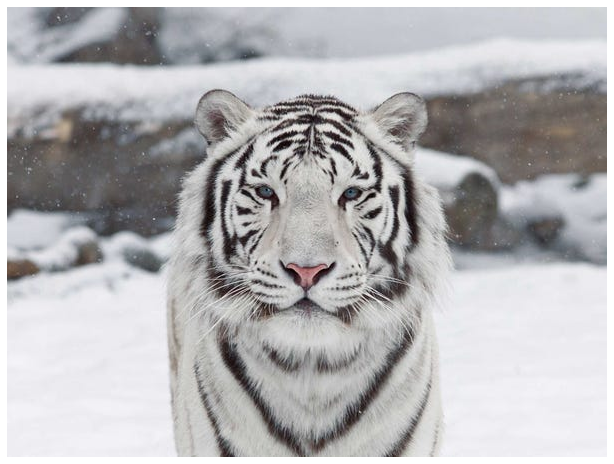

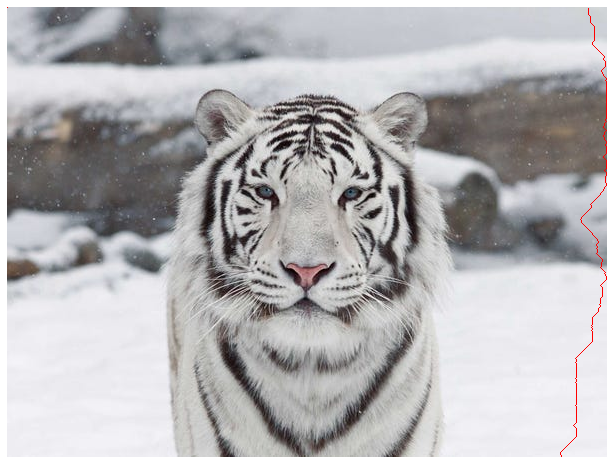

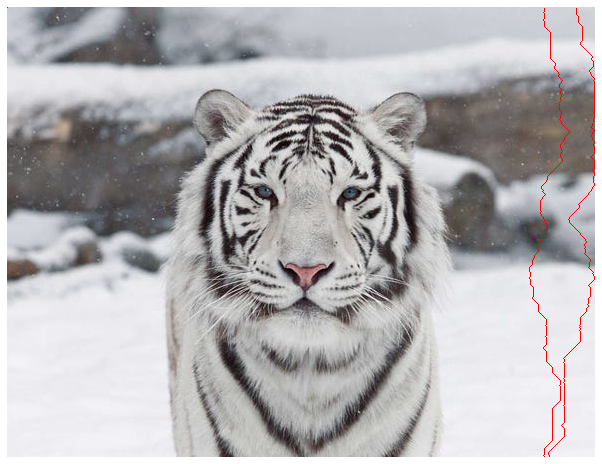

In [36]:
# TESTING

import matplotlib as mpl
def display_image_in_actual_size(im, title = ""):
#This function was directly sourced from: https://rb.gy/nbkluq
    dpi = mpl.rcParams['figure.dpi']
    # im_data = plt.imread(im_path)
    im_data = im
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data)

    plt.title(title)

    plt.show()








im_list = [cv2.imread('000000022969.jpg'), 
           cv2.imread('574100c6e31a1dcd096476eb2d632b3c.jpg'), 
           cv2.imread('8b01a894fb91025a1dc77611838e9d13.jpg'), 
           cv2.imread('000000046872.jpg'),
           cv2.imread('925f179ba736e15e89bfd6d88e0bba56.jpg'),
           cv2.imread('000000050145.jpg'),
           cv2.imread('e9b6826aa623549ec77bbc0275002779.jpg'), 
           cv2.imread('wildlife.jpg'),
           cv2.imread('white_tiger.jpg'),
           cv2.imread('white.jpg')
           ]

  #  cv2.imread('resized_im.jpg')
im = [cv2.cvtColor(im_list[i], cv2.COLOR_RGB2BGR) for i in range(len(im_list))]

# plt.imshow(im[5])


def test_drawseam():
  display_image_in_actual_size(im[-1])
  seams = seamIndex(im[-1])
  display_image_in_actual_size(draw_seams(im[-1], seams))
  energy_image = reduceImageColumns(im[-1], 0.98)
  seams = seamIndex(energy_image)
  display_image_in_actual_size(draw_seams(energy_image, seams))

def test_imagerotate():
  display_image_in_actual_size(im[0])
  rotated_im = image_rotate(im[0], True)
  display_image_in_actual_size(rotated_im)

def testEnergy():
    # fig = plt.figure(figsize=(10, 7))
    display_image_in_actual_size(im[0])
    energy_image = computeEnergy(im[0])
    display_image_in_actual_size(energy_image)

    return

# def testEnergyMap():
#     return

# def testSeamCarving():
#     return

def test_transpose():
    display_image_in_actual_size(im[0], "Actual image")
    transpose_image = image_transpose(im[0])
    display_image_in_actual_size(transpose_image, "Transposed Image")
    return

# def testSeamCarving_2D():
#     return

def testReduceColumns(scale):
    display_image_in_actual_size(im[-1], "Actual image")
    energy_image = reduceImageColumns(im[-1], scale)
    display_image_in_actual_size(energy_image, "")
    return


def testDisplayImage():
  im = cv2.imread('r1.jpg')
  display_image_in_actual_size(im)
  new_im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
  display_image_in_actual_size(new_im)


def testEnlarge():
    display_image_in_actual_size(im[0], "Actual image")
    enlarged_image = enlarge(im[0], 1.2)
    display_image_in_actual_size(enlarged_image/255, "Enlarged Image")
    return

def testEnlarge2D():
    display_image_in_actual_size(im[0], "Actual image")
    enlarged_image = enlarge2D(im[0], 1.1, 1.1)
    display_image_in_actual_size(enlarged_image/255, "Enlarged 2D Image")
    return
    

if __name__ == '__main__':
    # testDisplayImage()
    test_drawseam()
    # test_imagerotate()
    # testEnergy()
    # testEnergyMap()
    # test_transpose()
    # testReduceColumns(0.6)
    # testSeamCarving_2D()
    # testEnlarge()
    # testEnlarge2D()
